In [3]:
%matplotlib inline
from structurefunction import structure_function
import numpy as np
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import astropy.units as u
import os
import shutil

The second-order structure function of rotation measure (RM) is given by:

$$ SF_{\text{RM},\text{obs}}(\delta\theta) = \langle[\text{RM}{\theta} - \text{RM}(\theta+\delta\theta)]^2\rangle$$

That is, the ensemble average of the squared-difference in RM for sources with angular seperation $\delta\theta$. We also need to correct for the impact of errors by:

$$ SF_{\text{RM}}(\delta\theta) = SF_{\text{RM},\text{obs}}(\delta\theta) - SF_{\sigma_\text{RM}}(\delta\theta) $$

See Haverkorn et al. 2004 (2004ApJ...609..776H) for details.

Here we'll reproduce the results of Mao et al. 2010 (2010ApJ...714.1170M).

First, we can look at the expected results. I've pulled these data from the paper's plots using a web plot digitiser.

In [4]:
mao_sf = 10**np.array([2.417894195735458,
                    2.097768739428083,
                    2.2926445508823967,
                    2.164149088774578,
                    2.1404402085381147,
                    2.176621779798478,
                    2.218782670913379,
                    2.2444782900152482,
                    2.2476963207124476,
                    2.2837806390213578,]) * (u.rad / u.m**2)**2
mao_sep = 10**np.array([-0.7729091483767441, 
                    -0.5386163683663935, 
                    -0.2730532911440767, 
                    -0.02550632317850443, 
                    0.21819567988496358, 
                    0.47213008276920787, 
                    0.7173429798998987, 
                    0.9643533199726302, 
                    1.18882007856649, 
                    1.3453070240944185,]) * u.deg

Text(0, 0.5, 'RM SF [$\\mathrm{rad^{2}\\,m^{-4}}$]')

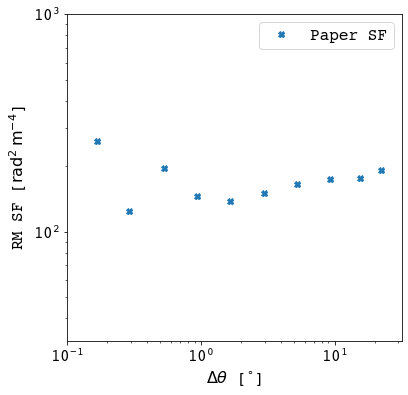

In [5]:
plt.figure(figsize=(6,6))
plt.plot(mao_sep, mao_sf, 'X', label='Paper SF')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**1.5, 10**3)
plt.xlim(10**-1,10**1.5)
plt.legend()
plt.xlabel(rf"$\Delta\theta$ [{mao_sep.unit:latex_inline}]")
plt.ylabel(rf"RM SF [{mao_sf.unit:latex_inline}]")

Now we'll start with the original data. We'll convert the data to an astropy table for convenience

In [6]:
with open('apj343194t1_mrt.txt') as f:
    lines = f.readlines()
for i, line in enumerate(tqdm(lines)):
    lines[i] = line.strip()
coords, rms, e_rms, flags, incs = [], [], [], [], []
for i, line in enumerate(tqdm(lines)):
    ra = f"{line[0:2]}h{line[3:5]}m{line[6:11]}s"
    #print(ra)
    dec = f"{line[12]}{line[13:15]}d{line[16:18]}m{line[19:24]}s"
    coord = SkyCoord(ra, dec)
    rm = float(line[39:42]) * (u.rad / u.m**2)
    e_rm = float(line[43:45]) * (u.rad / u.m**2)
    inc = line[63] == 'Y'
    incs.append(inc)
    try:
        flag = line[67]
    except:
        flag = None
    coords.append(coord)
    rms.append(rm)
    e_rms.append(e_rm)
    flags.append(flag)

mao_rm_tab = Table()
mao_rm_tab.add_column(coords, name='coordinates')
mao_rm_tab.add_column(rms, name='RM')
mao_rm_tab.add_column(e_rms, name='e_RM')
mao_rm_tab.add_column(incs, name='included')
mao_rm_tab.add_column(flags, name='flag')

mao_rm_tab

  0%|          | 0/472 [00:00<?, ?it/s]

  0%|          | 0/472 [00:00<?, ?it/s]

coordinates,RM,e_RM,included,flag
"deg,deg",rad / m2,rad / m2,,
SkyCoord,float64,float64,bool,object
"196.78470833333333,24.78352777777778",-3.0,4.0,True,None
"203.9505833333333,20.171111111111113",3.0,5.0,False,b
"201.06033333333332,22.220305555555555",-6.0,6.0,True,None
"201.07991666666663,22.233472222222222",0.0,6.0,True,None
"199.01816666666664,23.62713888888889",4.0,13.0,True,None
"200.20225,22.965194444444442",-6.0,8.0,True,None
"197.81804166666666,24.454333333333334",5.0,3.0,True,None
"203.60637499999996,21.167916666666667",-1.0,9.0,False,b


Now we'll define our own bin edges to compute a structure function

In [7]:
start = -0.8
stop = 1.5
step = 0.1
bins = 10**np.arange(start, stop+step, step)*u.deg

In [8]:
bins.max()

<Quantity 39.81071706 deg>

Here we compute the strcture function itself, including error correction. We use 1000 samples of each distribution for error propagation.

By setting `show_plots=True` three plots are shown. 
1. An error-bar plot of the SF.
2. A count of the number of source pairs per SF bin
3. A structure function image showing the sampling from Monte-Carlo error propagation

The `structure_function` function returns the centre of each bin, the median value of each bin, the upper and lower error bounds, and the number of sources in each bin.

By setting `fit` we use `bilby` to do a best-fit of the SF with a broken power law. Here we're using `nestle` to do the sampling. All `**kwargs` are passed onto the `run_sampler` method of `bilby`.

In [9]:
# Clean up if a previous run was done
if os.path.exists("outdir"):
    shutil.rmtree("outdir")

2024-05-21 16:14:06.549 INFO structurefunction - structure_function: Sampling errors...
2024-05-21 16:14:06.628 INFO structurefunction - structure_function: Getting angular separations...
2024-05-21 16:14:06.640 INFO structurefunction - structure_function: Computing SF...


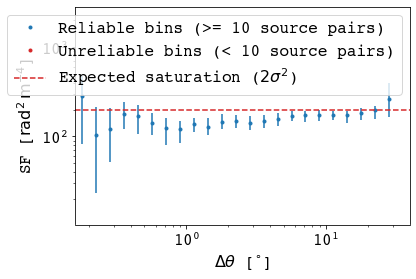

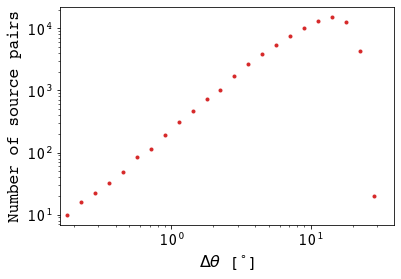

In [13]:
sf_result, result = structure_function(
    data=mao_rm_tab['RM'][mao_rm_tab['included']],
    errors=mao_rm_tab['e_RM'][mao_rm_tab['included']],
    coords=mao_rm_tab['coordinates'][mao_rm_tab['included']],
    samples=100,
    bins=bins,
    show_plots=True,
    verbose=True,
)

2024-05-20 15:44:24.080 INFO structurefunction - structure_function: Sampling errors...
2024-05-20 15:44:24.881 INFO structurefunction - structure_function: Getting angular separations...
2024-05-20 15:44:24.904 INFO structurefunction - structure_function: Computing SF...
2024-05-20 15:44:35.069 INFO structurefunction - fit_data: Fitting SF with a power law...
15:44 bilby INFO    : Running for label 'power_law_2_point', output will be saved to 'outdir'
python(13685) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
15:44 bilby INFO    : Analysis priors:
15:44 bilby INFO    : amplitude=Uniform(minimum=141.68911917098447, maximum=328.3, name='amplitude', latex_label='$a$', unit=None, boundary=None)
15:44 bilby INFO    : x_break=Uniform(minimum=0.179, maximum=28.371000000000002, name='x_break', latex_label='$\\theta_\\mathrm{break}$', unit=None, boundary=None)
15:44 bilby INFO    : alpha=Uniform(minimum=-2, maximum=2, name='alpha', latex_label='$\\alpha$'

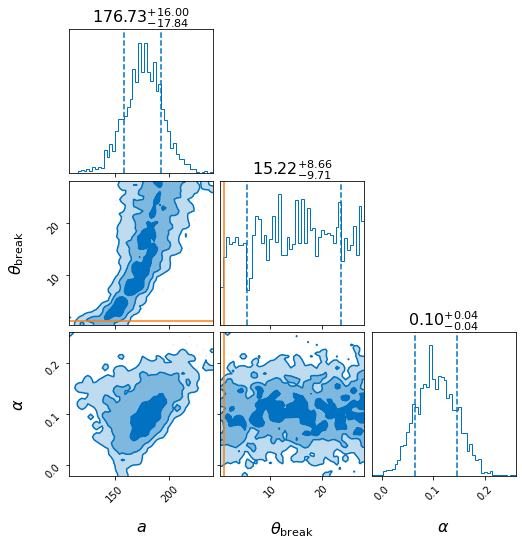

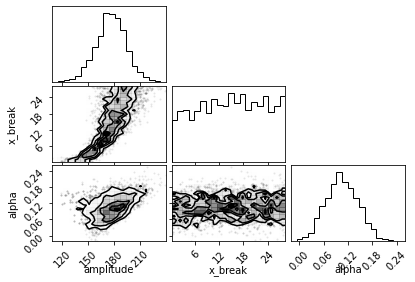

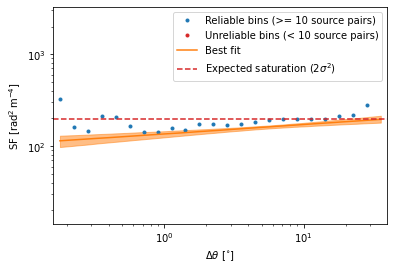

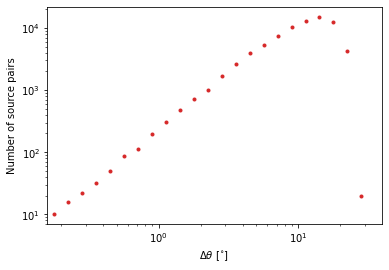

In [85]:


sf_result, result = structure_function(
    data=np.array(mao_rm_tab['RM'][mao_rm_tab['included']]) * u.rad / u.m**2,
    errors= np.zeros(len(mao_rm_tab['e_RM'][mao_rm_tab['included']])) * u.rad / u.m**2,
    coords=mao_rm_tab['coordinates'][mao_rm_tab['included']],
    samples=1000,
    bins=bins,
    show_plots=True,
    verbose=True,
    fit='bilby',
    nlive=400,
    sampler='nestle',
    model_name='power_law',
)

In [27]:
sf_result

SFResult(med=array([1156.        , 2704.        ,   33.75      ,  929.14285714,
        401.81818182,  306.6744186 ,  386.79569892,  486.44559585,
        423.76997579,  531.88009592,  547.55640244,  516.79188779,
        541.10046885,  562.44919481,  616.79434961,  625.0599791 ,
        640.91616253,  634.71064579,  632.83424951,  677.92811831,
        703.02968147,  812.        ]), err_low=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.]), err_high=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.]), count=array([    1,     1,     4,     7,    22,    43,    93,   193,   413,
         834,  1312,  2638,  4479,  7017, 10017, 14355, 19836, 25550,
       29834, 24749,  8288,    24]), c_bins=<Quantity [ 0.2255,  0.2835,  0.357 ,  0.4495,  0.566 ,  0.7125,  0.897 ,
            1.1295,  1.422 ,  1.79  ,  2.2535,  2.837 ,  3.5715,  4.4965,
            5.661 ,  7.1265,  8.9715, 11.2945, 14.

We can compare our results to those from the original paper.

Text(0, 0.5, 'RM SF [$\\mathrm{rad^{2}\\,m^{-4}}$]')

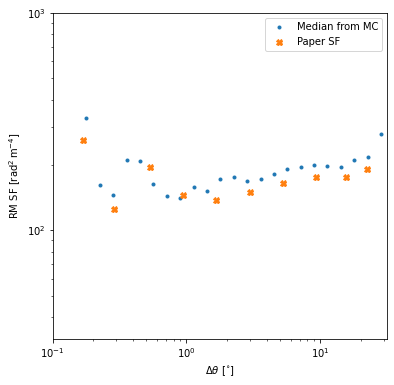

In [86]:
plt.figure(figsize=(6,6), facecolor='w')
plt.plot(sf_result.c_bins, sf_result.med, '.', label='Median from MC')
plt.errorbar(sf_result.c_bins, sf_result.med, yerr=[sf_result.err_low, sf_result.err_high], color='tab:blue', marker=None, fmt=' ', )#label = '16th to 84th percentile range')
plt.plot(mao_sep, mao_sf, 'X', label='Paper SF')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**1.5, 10**3)
plt.xlim(10**-1,10**1.5)
plt.legend()
plt.xlabel(rf"$\Delta\theta$ [{mao_sep.unit:latex_inline}]")
plt.ylabel(rf"RM SF [{mao_sf.unit:latex_inline}]")

Finally, we extend to using mutli-point structure functions, as described by Seta et al. 2022 (10.1093/mnras/stac2972). Currently, only the triple-point structure function is implemented.

In [89]:
len(mao_rm_tab['RM'][mao_rm_tab['included']])

400

In [88]:
sf_result, result = structure_function(
    data=np.array(mao_rm_tab['RM'][mao_rm_tab['included']]) * u.rad / u.m**2,
    errors=np.zeros(len(np.array(mao_rm_tab['RM'][mao_rm_tab['included']]))) * u.rad / u.m**2,
    coords=mao_rm_tab['coordinates'][mao_rm_tab['included']],
    samples=1000,
    bins=bins,
    show_plots=True,
    verbose=True,
    fit='bilby',
    nlive=400,
    sampler='nestle',
    model_name='power_law',
    n_point=3
)

2024-05-20 15:46:49.067 INFO structurefunction - structure_function: Sampling errors...
2024-05-20 15:46:49.802 INFO structurefunction - structure_function: Getting angular separations...
2024-05-20 15:46:49.817 INFO structurefunction - structure_function: Computing SF...
2024-05-20 15:46:56.046 INFO structurefunction - flush: Grouping triplets:   0%|          | 0/23 [00:00<?, ?it/s]
2024-05-20 15:47:03.707 INFO structurefunction - flush: Grouping triplets:   4%|4         | 1/23 [00:07<02:48,  7.66s/it]
2024-05-20 15:47:06.160 INFO structurefunction - flush: Grouping triplets:   9%|8         | 2/23 [00:10<01:36,  4.60s/it]
2024-05-20 15:47:11.750 INFO structurefunction - flush: Grouping triplets:  13%|#3        | 3/23 [00:15<01:40,  5.05s/it]
2024-05-20 15:47:11.957 INFO structurefunction - flush: Grouping triplets:  17%|#7        | 4/23 [00:15<00:59,  3.14s/it]
2024-05-20 15:47:22.367 INFO structurefunction - flush: Grouping triplets:  26%|##6       | 6/23 [00:26<01:11,  4.23s/it]
202

SystemExit: 130

In [69]:
sf_result

SFResult(med=array([295.42948699, 121.36934131, 120.09353314, 189.99370354,
       176.51554329, 139.90568197, 122.36212314, 117.48545892,
       136.23636949, 127.61644976, 152.08669009, 154.18447602,
       145.37688096, 150.75260303, 157.84494148, 171.95061038,
       172.36877057, 175.29180173, 174.4166209 , 172.14897258,
       186.04900143, 191.37169018, 254.71995301,          nan]), err_low=array([170.5982165 ,  92.55629469,  69.14715345,  69.33552004,
        66.78265795,  47.37260933,  40.05946906,  30.68290696,
        24.43260037,  27.00469745,  26.6033074 ,  26.75704721,
        24.52421568,  22.66421843,  21.69176252,  22.85708438,
        23.70418153,  21.72399129,  21.05463306,  21.44889456,
        26.33993227,  33.30642471, 128.33203541,          nan]), err_high=array([193.80449276, 109.50372689,  79.36899835,  72.74734737,
        69.91013288,  48.24837233,  39.13355786,  32.16704959,
        28.98515279,  27.73523201,  24.8219864 ,  24.72228982,
        25.11610166, 

([<matplotlib.axis.YTick at 0x7fc269de5a60>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

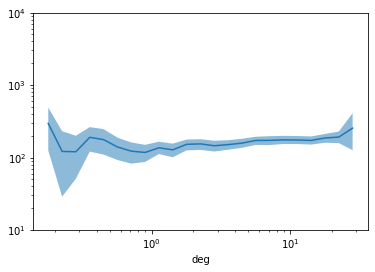

In [79]:
plt.fill_between(sf_result[-1], sf_result[0] - sf_result[1], sf_result[0] + sf_result[2], alpha = 0.5)
plt.plot(sf_result[-1], sf_result[0])
plt.loglog()
plt.yticks((10**1, 10**2, 10**3, 10**4))

In [16]:
old_egal_rm

array(<nifty8.Field>, dtype=object)

6436 6436


2024-05-21 18:08:34.319 INFO structurefunction - structure_function: Sampling errors...
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2024-05-21 18:08:40.975 INFO structurefunction - structure_function: Getting angular separations...
2024-05-21 18:08:47.970 INFO structurefunction - structure_function: Computing SF...
2024-05-21 18:14:13.666 INFO structurefunction - structure_function: Sampling errors...
2024-05-21 18:14:14.432 INFO structurefunction - structure_function: Getting angular separations...
2024-05-21 18:14:19.348 INFO structurefunction - structure_function: Computing SF...
2024-05-21 18:16:06.537 INFO structurefunction - structure_function: Sampling errors...
2024-05-21 18:16:11.348 INFO structurefunction - structure_function: Getting angular separations...
2024-05-21 18:16:17.387 INFO structurefunction - structure_function: Computing SF...


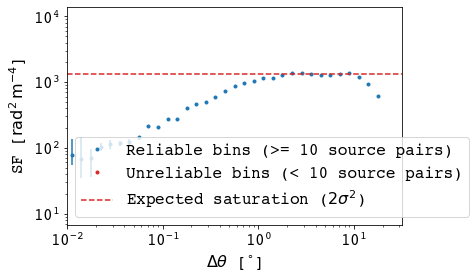

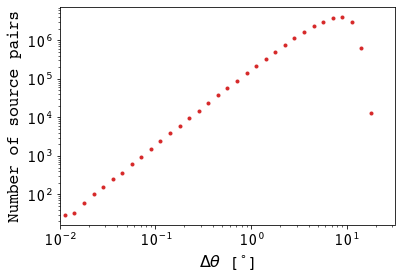

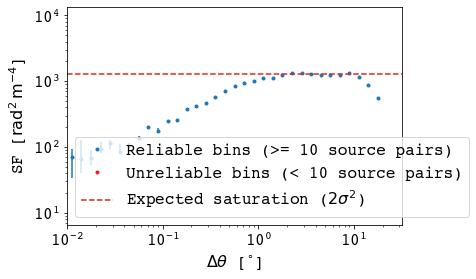

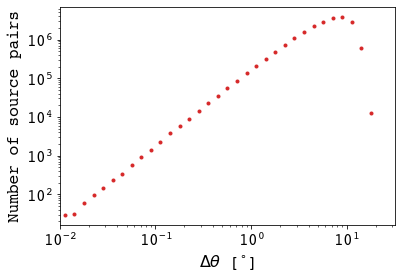

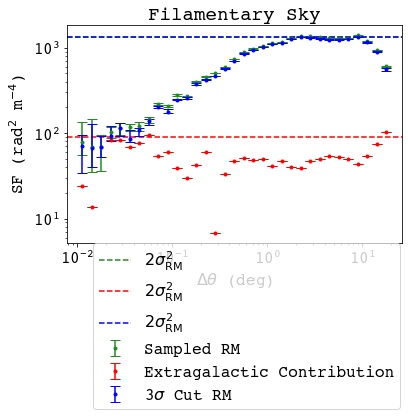

6310 6310


2024-05-21 18:22:04.485 INFO structurefunction - structure_function: Sampling errors...
2024-05-21 18:22:09.628 INFO structurefunction - structure_function: Getting angular separations...
2024-05-21 18:22:16.494 INFO structurefunction - structure_function: Computing SF...
2024-05-21 18:28:13.292 INFO structurefunction - structure_function: Sampling errors...
2024-05-21 18:28:14.058 INFO structurefunction - structure_function: Getting angular separations...
2024-05-21 18:28:19.012 INFO structurefunction - structure_function: Computing SF...
2024-05-21 18:30:15.436 INFO structurefunction - structure_function: Sampling errors...
2024-05-21 18:30:20.081 INFO structurefunction - structure_function: Getting angular separations...
2024-05-21 18:30:26.105 INFO structurefunction - structure_function: Computing SF...


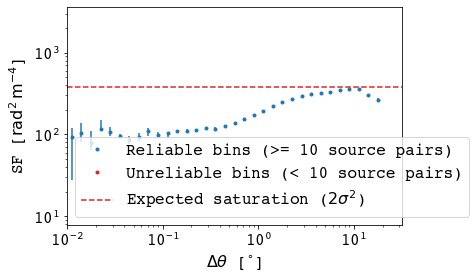

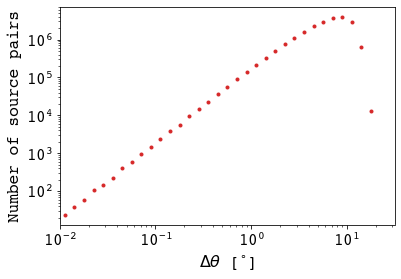

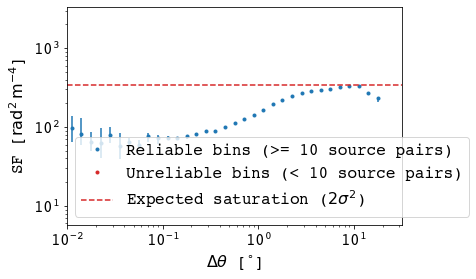

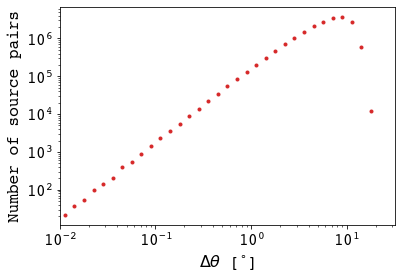

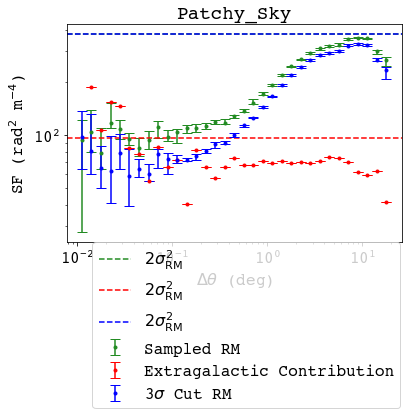

In [36]:

from typing import Union
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Courier"
# Loading in the interpolated RM maps 

def nanvar(data: Union[np.ndarray, u.Quantity]) -> Union[np.ndarray, u.Quantity]:
    """Compute the variance of an array, ignoring NaNs

    Args:
        data (Union[np.ndarray, u.Quantity]): Array

    Returns:
        Union[np.ndarray, u.Quantity]: Variance
    """

    mask = ~np.isfinite(data)
    return np.var(data[~mask])
# Here, we will load in the coordinates and turn the arrays into a form that structurefunction can work with, i.e, (ra, dec) coordinatates with corresponding RN values
# and setting err_RM = 0


paths = ['../../Data/simulated_fil/test/', '../../Data/simulated_patchy/test/']
cutout_paths = ['../../Data/simulated_cutout_fil/test/', '../../Data/simulated_cutout_patchy/test/']

plot_names = ['Filamentary Sky', 'Patchy_Sky']
for i in range(len(paths)):
    path = paths[i]
    cut_path = cutout_paths[i]

    old_data = np.load(path+"data.npy")
    old_phi = np.load(path+"phi.npy")
    old_theta =np.load(path+"theta.npy")
    old_egal_rm = np.load(path + "extragal_rm.npy", allow_pickle = True)
    old_rm_noise = np.load(path + "noise.npy")
    old_egal_noise = np.load(path + "extragal_sigma.npy", allow_pickle = True)

    old_data_2 = old_data[np.where(old_theta < 0)]
    old_phi_2 = old_phi[np.where(old_theta < 0)]
    old_theta_2 = old_theta[np.where(old_theta < 0)]
    old_egal_rm_2 = old_egal_rm[np.where(old_theta < 0)]
    old_rm_noise_2 = old_rm_noise[np.where(old_theta < 0)]
    old_egal_noise_2 = old_egal_noise[np.where(old_theta < 0)]

    data = old_data_2[np.where(old_phi_2 < 0)]
    phi = old_phi_2[np.where(old_phi_2 < 0)]
    theta = old_theta_2[np.where(old_phi_2 < 0)]
    egal_rm = old_egal_rm_2[np.where(old_phi_2 < 0)]
    rm_noise = old_rm_noise_2[np.where(old_phi_2 < 0)]
    egal_noise = old_egal_noise_2[np.where(old_phi_2 < 0)]

    theta = -theta
    phi = -phi

    cut_data = np.load(cut_path + "data.npy")
    cut_theta = np.load(cut_path + "theta.npy")
    cut_phi = np.load(cut_path  + "phi.npy")
    cut_rm_noise = np.load(cut_path + "noise.npy")


    points = np.vstack((theta, phi)).T 
    points_astro = []

    for point in points:
        points_astro.append(SkyCoord(point[0], point[1], unit = 'deg'))

    cut_points = np.vstack((cut_theta, cut_phi)).T
    cut_points_astro = []
    for cut_point in cut_points:
        cut_points_astro.append(SkyCoord(cut_point[0], cut_point[1], unit ='deg'))
    print(len(cut_data), len(cut_points_astro))
    sim_tab = Table()
    
    sim_tab.add_column(points_astro, name = 'coords')
    sim_tab.add_column(data, name = 'RM')
    sim_tab.add_column(rm_noise, name = 'e_RM')
    sim_tab.add_column(egal_rm, name = 'egal_RM')
    sim_tab.add_column(egal_noise, name = 'err_egal_RM')

    cut_tab = Table()
    cut_tab.add_column(cut_points_astro, name = 'cut_coords')
    cut_tab.add_column(cut_data, name = 'cut_RM')
    cut_tab.add_column(cut_rm_noise, name = 'cut_e_RM')

    start = -2
    stop = 1.5
    step = 0.1
    bins = 10**np.arange(start, stop+step, step)*u.deg

    data_sf, data_result  = structure_function(data = sim_tab['RM'] * (u.rad/u.m**2), errors = sim_tab['e_RM'] * (u.rad/u.m**2), coords = sim_tab['coords'], 
                                                samples = 10, bins=bins, show_plots=True, verbose=True) 

    egal_sf, egal_result = structure_function(data = sim_tab['egal_RM'] * (u.rad/u.m**2), errors = sim_tab['err_egal_RM'] * (u.rad/u.m**2), coords = sim_tab['coords'], 
                                                samples = 1, bins  = bins, show_plots = False, verbose = False)
    cut_sf, cut_result  = structure_function(data = cut_tab['cut_RM'] * (u.rad/u.m**2), errors = cut_tab['cut_e_RM'] * (u.rad/u.m**2), coords = cut_tab['cut_coords'], 
                                                samples = 10, bins=bins, show_plots=True, verbose=True) 
    colors = ['forestgreen', 'red', 'blue']
    fig, ax = plt.subplots()
    med = data_sf[0]
    err_low = data_sf[1]
    err_high = data_sf[2]
    c_bins = data_sf[-1]

    ax.errorbar(c_bins, med, yerr = (err_low, err_high), label = 'Sampled RM', color = colors[0], fmt = '.', capsize = 5)

    ax.axhline(2 * nanvar(sim_tab['RM']), linestyle = '--', color = colors[0], label = '$2\sigma_{\mathrm{RM}}^2$')

    med = egal_sf[0]
    err_low = egal_sf[1]
    err_high = egal_sf[2]
    c_bins = egal_sf[-1]

    ax.errorbar(c_bins, med, yerr = (err_low, err_high), label = 'Extragalactic Contribution', color = colors[1], fmt = '.', capsize = 5)

    ax.axhline(2 * nanvar(sim_tab['egal_RM']), linestyle = '--', color = colors[1], label = '$2\sigma_{\mathrm{RM}}^2$')

    med = cut_sf[0]
    err_low = cut_sf[1]
    err_high = cut_sf[2]
    c_bins = cut_sf[-1]

    ax.errorbar(c_bins, med, yerr = (err_low, err_high), label = '3$\sigma$ Cut RM', color = colors[2], fmt = '.', capsize = 5)

    ax.axhline(2 * nanvar(sim_tab['RM']), linestyle = '--', color = colors[2], label = '$2\sigma_{\mathrm{RM}}^2$')

    ax.set_title(plot_names[i])
    ax.set_xlabel('$\Delta \\theta$ (deg)')
    ax.set_ylabel('SF (rad$^2$ m$^{-4}$)')
    handles, labels = plt.gca().get_legend_handles_labels()
    order = [3, 0, 4, 1, 5, 2]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor = (1.02, -1.05), loc = 'lower right')
    ax.loglog()
    plt.show()

In [18]:
len(cut_points_astro)

6436

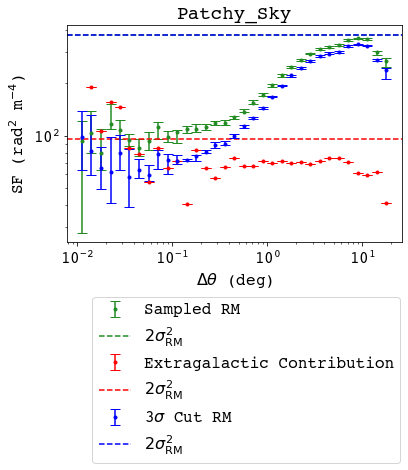

In [44]:
colors = ['forestgreen', 'red', 'blue']
fig, ax = plt.subplots()
med = data_sf[0]
err_low = data_sf[1]
err_high = data_sf[2]
c_bins = data_sf[-1]

ax.errorbar(c_bins, med, yerr = (err_low, err_high), label = 'Sampled RM', color = colors[0], fmt = '.', capsize = 5)

ax.axhline(2 * nanvar(sim_tab['RM']), linestyle = '--', color = colors[0], label = '$2\sigma_{\mathrm{RM}}^2$')

med = egal_sf[0]
err_low = egal_sf[1]
err_high = egal_sf[2]
c_bins = egal_sf[-1]

ax.errorbar(c_bins, med, yerr = (err_low, err_high), label = 'Extragalactic Contribution', color = colors[1], fmt = '.', capsize = 5)

ax.axhline(2 * nanvar(sim_tab['egal_RM']), linestyle = '--', color = colors[1], label = '$2\sigma_{\mathrm{RM}}^2$')

med = cut_sf[0]
err_low = cut_sf[1]
err_high = cut_sf[2]
c_bins = cut_sf[-1]

ax.errorbar(c_bins, med, yerr = (err_low, err_high), label = '3$\sigma$ Cut RM', color = colors[2], fmt = '.', capsize = 5)

ax.axhline(2 * nanvar(sim_tab['RM']), linestyle = '--', color = colors[2], label = '$2\sigma_{\mathrm{RM}}^2$')

ax.set_title(plot_names[i])
ax.set_xlabel('$\Delta \\theta$ (deg)')
ax.set_ylabel('SF (rad$^2$ m$^{-4}$)')
handles, labels = plt.gca().get_legend_handles_labels()
order = [3, 0, 4, 1, 5, 2]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], bbox_to_anchor = (1.02, -1.05), loc = 'lower right')
ax.loglog()
plt.show()